## 1. Environment Setup
Importing necessary libraries for data manipulation, visualization, and modeling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

import os

## 2. Data Ingestion
Merging multiple CSV files from the raw data directory into a single DataFrame. We also handle basic date parsing here to ensure chronological sorting.

In [ ]:
folder_path = 'Kickstarter_2025-11-12T12_09_07_111Z' 
dataframes = []

for filename in os.listdir(folder_path):
    # exact case match for "Kickstart"
    if filename.startswith("Kickstart") and filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        
        # Read file
        try:
            df_single = pd.read_csv(file_path, encoding='utf-8') 
            dataframes.append(df_single)
        except Exception as e:
            print(f"Skipped {filename} due to error: {e}")

# Merge all CSVs into one DataFrame named df
if len(dataframes) > 0:
    df = pd.concat(dataframes, ignore_index=True)
    
    # 1. Convert to datetime
    df['launched_at'] = pd.to_datetime(df['launched_at'])
    
    # 2. Sort Oldest -> Newest
    df = df.sort_values(by='launched_at')
    # --------------------------------
    
    print(f"Successfully merged {len(dataframes)} files.")
    print(f"Total rows: {df.shape[0]}")
    print("Data is now sorted chronologically.")
else:
    print("No files found matching 'Kickstart*.csv'")

Successfully merged 83 files.
Total rows: 265019
Data is now sorted chronologically.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265019 entries, 11529 to 209838
Data columns (total 42 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   backers_count                       265019 non-null  int64         
 1   blurb                               264909 non-null  object        
 2   category                            265019 non-null  object        
 3   converted_pledged_amount            248444 non-null  float64       
 4   country                             265019 non-null  object        
 5   country_displayable_name            265019 non-null  object        
 6   created_at                          265019 non-null  int64         
 7   creator                             265019 non-null  object        
 8   currency                            265019 non-null  object        
 9   currency_symbol                     265019 non-null  object        
 10  currency_

In [4]:
# 1. Convert the Unix timestamp to a readable datetime
df['created_at'] = pd.to_datetime(df['created_at'], unit='s')

# 2. Sort by 'created_at' in descending order (Newest first) and show top 10
newest_entries = df.sort_values(by='created_at', ascending=False)[['created_at', 'id']].head(10)

print(newest_entries)
print("Oldest Date:", df['created_at'].min())
print("Newest Date:", df['created_at'].max())

                created_at          id
127416 2025-11-12 03:31:54   983597534
251650 2025-11-12 03:31:54   983597534
205180 2025-11-12 03:31:54   983597534
229988 2025-11-12 02:17:28  1529951998
151307 2025-11-12 02:17:28  1529951998
245598 2025-11-12 02:17:28  1529951998
85790  2025-11-12 02:12:06  1280333238
259248 2025-11-12 02:12:06  1280333238
130943 2025-11-12 02:12:06  1280333238
94103  2025-11-12 00:08:33   988616305
Oldest Date: 2009-04-22 02:11:10
Newest Date: 2025-11-12 03:31:54


## 3. Feature Engineering & Preprocessing
Here we transform raw columns into machine-readable features:
- **Temporal Features:** Calculating campaign duration.
- **Log Transformation:** Normalizing 'goal' amounts.
- **Text Features:** Extracting lengths from campaign names/blurbs.
- **Train/Test Split:** Using a time-series split to respect the temporal nature of the data.

In [ ]:

# 1. Strict Filtering
df = df[df['state'].isin(['successful', 'failed'])].copy()

# 2. Create Target Variable (1 = Success, 0 = Fail)
df['target'] = df['state'].apply(lambda x: 1 if x == 'successful' else 0)

# 3. Feature Engineering

# 1. Convert created_at to datetime 
df['launched_at'] = pd.to_datetime(df['created_at'], unit='s')

# 2. Convert deadline
df['deadline'] = pd.to_datetime(df['deadline'], unit='s', errors='coerce')

# A. Temporal Features
df['duration_days'] = (df['deadline'] - df['launched_at']).dt.days

df = df[
    (df['duration_days'] > 0) & 
    (df['duration_days'] <= 100)
].copy()

df['launch_month'] = df['launched_at'].dt.month
df['launch_day'] = df['launched_at'].dt.dayofweek

# B. Financial Features
df['log_goal'] = np.log1p(df['goal']) 

# C. Text Features
df['name_len'] = df['name'].astype(str).apply(len)
df['blurb_len'] = df['blurb'].astype(str).apply(len)
df['name_word_count'] = df['name'].astype(str).apply(lambda x: len(x.split()))

# 4. Prepare for Encoding
features = [
    'log_goal', 
    'duration_days', 
    'launch_month', 
    'launch_day', 
    'name_len', 
    'blurb_len', 
    'name_word_count',
    'country', 
    'category'
]
# Create a clean DataFrame for modeling that includes the Split Key (launched_at) and Target
df_model = df[features + ['launched_at', 'target']].copy()

# 5. One-Hot Encoding 
df_model = pd.get_dummies(df_model, columns=['country', 'category'], drop_first=True)

# 1. Split Date on October as per Arturo's Email
split_date = '2025-10-01'
# 2. Re-create the masks
train_mask = df_model['launched_at'] < split_date
test_mask  = df_model['launched_at'] >= split_date

# 3. Create X and y again
X_train = df_model.loc[train_mask].drop(columns=['target', 'launched_at'])
y_train = df_model.loc[train_mask, 'target']

X_test = df_model.loc[test_mask].drop(columns=['target', 'launched_at'])
y_test = df_model.loc[test_mask, 'target']

# 4. Check the new Test Set Volume 
print(f"New Test Set Size: {len(y_test)}")
print("Class Balance in Test Set:")
print(y_test.value_counts())

# 7. Verification
print(f"Training Range: {df.loc[train_mask, 'launched_at'].min()} to {df.loc[train_mask, 'launched_at'].max()}")
print(f"Testing Range:  {df.loc[test_mask, 'launched_at'].min()} to {df.loc[test_mask, 'launched_at'].max()}")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"New Test Set Size: {len(y_test)}")

New Test Set Size: 559
Class Balance in Test Set:
target
1    458
0    101
Name: count, dtype: int64
Training Range: 2009-04-22 02:11:10 to 2025-09-30 21:36:55
Testing Range:  2025-10-01 00:02:41 to 2025-11-09 02:31:22
Train shape: (186358, 201), Test shape: (559, 201)
New Test Set Size: 559


## 4. Model Benchmarking
We run a "tournament" of five standard classifiers to establish a baseline performance. The metric of choice is Accuracy, supported by AUC and F1-Score.

Running Model Tournament...
Testing Logistic Regression...
Testing Decision Tree...
Testing Random Forest...
Testing Gradient Boosting...
Testing XGBoost...

--- FINAL STANDINGS ---
                 Model  Accuracy  F1 Score     AUC  Precision  Recall
4              XGBoost    0.8837    0.9337  0.8599     0.8757  1.0000
2        Random Forest    0.8730    0.9250  0.8925     0.8957  0.9563
3    Gradient Boosting    0.8712    0.9267  0.8538     0.8683  0.9934
1        Decision Tree    0.8676    0.9228  0.8219     0.8840  0.9651
0  Logistic Regression    0.8479    0.9095  0.8327     0.8877  0.9323


/tmp/ipykernel_638/980159388.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


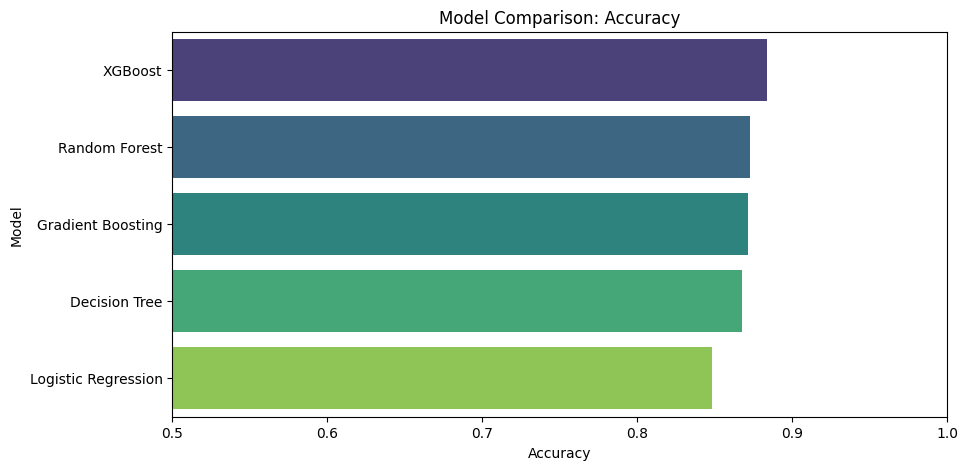


🏆 RECOMMENDATION: The best performing model is XGBoost.


In [ ]:
# 1. Define the Models to Test
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    
    "XGBoost": XGBClassifier(
        n_estimators=100, 
        learning_rate=0.05, 
        eval_metric='logloss', 
        random_state=42
    )
}

# 2. Running the Tournament
results = []

print("Running Model Tournament...")
for name, model in models.items():
    print(f"Testing {name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate Probabilities (for AUC) 
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = "N/A"

    # Store Metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": auc,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    })

# 3. Create a DataFrame & Sort by Accuracy
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

print("\n--- FINAL STANDINGS ---")
print(results_df.round(4))

# 4. Visualize the Winner
plt.figure(figsize=(10, 5))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Comparison: Accuracy')
plt.xlim(0.5, 1.0) 
plt.show()

# 5. Recommendation Logic
best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 RECOMMENDATION: The best performing model is {best_model_name}.")

## 5. Quick Model Optimization 
Fine-tuning the hyperparameters of our top-performing models using RandomizedSearchCV to squeeze out extra performance without overfitting.

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# 1. Setup Parameter Grids for Each Model That Was Taught in Class
param_grids = {
    "Logistic Regression": {
        'clf__C': uniform(0.1, 10),      
        'clf__solver': ['liblinear', 'lbfgs']
    },
    "Decision Tree": {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': randint(2, 20),
        'criterion': ['gini', 'entropy']
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'bootstrap': [True, False]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 9],
        'subsample': [0.7, 1.0]
    }
}

# 2. Define the Sampling
X_sample = X_train.sample(n=10000, random_state=42)
y_sample = y_train.loc[X_sample.index]

tuned_results = []

print("--- STARTING RAPID TUNING (Sample N=10,000) ---")

# 3. Loop Through All Models
for name, model in models.items():
    print(f"Tuning {name}...")
    
    # Select the correct param grid
    if name in param_grids:
        grid = param_grids[name]
    else:
        continue 
        
    # Run Random Search
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=grid,
        n_iter=5,
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    # Fit on the small sample
    search.fit(X_sample, y_sample)
    
    # Store Best Params & Score
    tuned_results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "Best CV Accuracy": search.best_score_
    })

# 4. Display the "Winning" Configuration for each
tuned_df = pd.DataFrame(tuned_results)
print("\n--- TUNED CONFIGURATIONS ---")
for index, row in tuned_df.iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Best Accuracy (on sample): {row['Best CV Accuracy']:.4f}")
    print(f"  Best Params: {row['Best Params']}")

--- STARTING RAPID TUNING (Sample N=10,000) ---
Tuning Logistic Regression...
Tuning Decision Tree...
Tuning Random Forest...


/home/saintk/Documents/My Github/datasci/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning Gradient Boosting...
Tuning XGBoost...

--- TUNED CONFIGURATIONS ---

Logistic Regression:
  Best Accuracy (on sample): 0.7630
  Best Params: {'clf__C': np.float64(0.6808361216819946), 'clf__solver': 'lbfgs'}

Decision Tree:
  Best Accuracy (on sample): 0.6906
  Best Params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 12}

Random Forest:
  Best Accuracy (on sample): 0.7572
  Best Params: {'n_estimators': 200, 'max_depth': None, 'bootstrap': True}

Gradient Boosting:
  Best Accuracy (on sample): 0.7552
  Best Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2}

XGBoost:
  Best Accuracy (on sample): 0.7650
  Best Params: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3}


--- ROC AUC SCORES ---
Logistic Regression: 0.8327
Decision Tree: 0.8219
Random Forest: 0.8925
Gradient Boosting: 0.8538
XGBoost: 0.8599


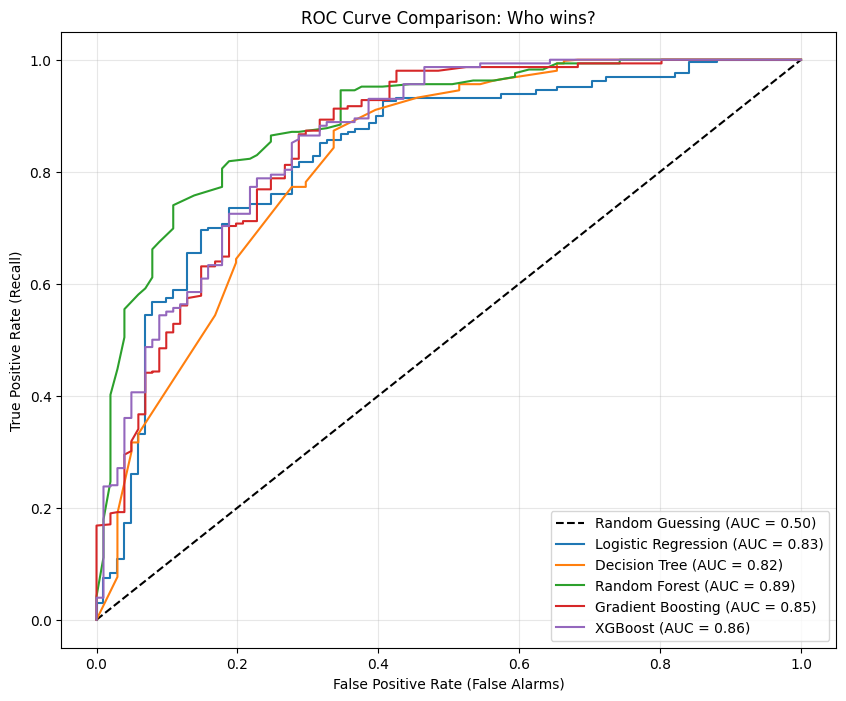

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
# 1. Setup the Plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')

print("--- ROC AUC SCORES ---")

# 2. Loop through your defined models
for name, model in models.items():
    
    # Train 
    model.fit(X_train, y_train)
    
    # Get Probabilities for Class 1 (Success)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate Score
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name}: {auc:.4f}")
    
    # Calculate Curve lines
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Add to Plot
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

# 3. Finalize Plot
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison: Who wins?')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# 1. Select Features for Clustering
cluster_cols = ['log_goal', 'duration_days', 'name_len', 'blurb_len', 'name_word_count']
X_cluster = df[cluster_cols].copy()

# 2. Standardization 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

## 6. Determining Optimal Clusters (Elbow Method)
Before segmenting the projects, we must determine the optimal number of clusters (`k`). We iterate through `k=1` to `k=9` and calculate the **Inertia** (sum of squared distances) to find the "Elbow Point"—the point where adding more clusters yields diminishing returns.

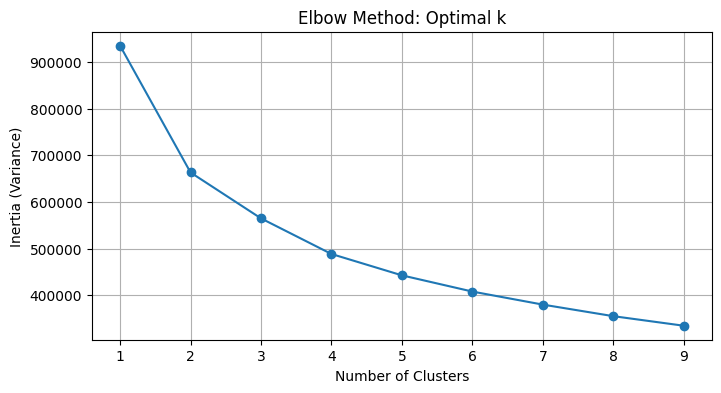

In [11]:
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Variance)')
plt.grid(True)
plt.show()

## 7. Model Fitting: K-Means
Based on the Elbow analysis, we selected **K=4** as the optimal number of distinct "Campaign Personas." We now fit the algorithm to the data to assign every project to one of these 4 groups.

         goal_mean  goal_median  duration_days_mean  blurb_len_mean  \
cluster                                                               
0         59239.95       5000.0               45.99          119.95   
1        104164.07      10000.0               67.99          113.87   
2         23797.16       3000.0               47.51           55.31   
3          4682.37       2000.0               35.34          112.98   

         target_mean  target_count  
cluster                             
0               0.57         56865  
1               0.66         43184  
2               0.65         37613  
3               0.72         49255  


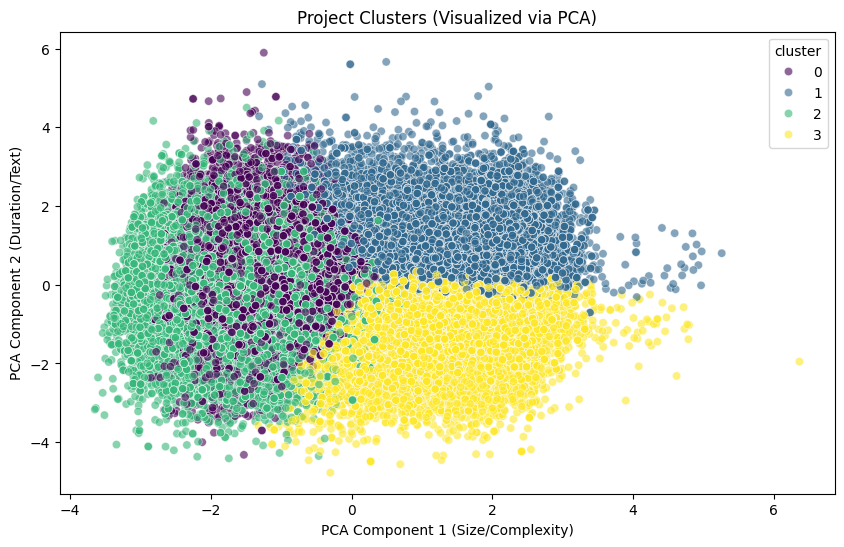

In [ ]:
# 1. Fit the Model
k = 4  
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 2. Generate the profile table
profile = df.groupby('cluster').agg({
    'goal': ['mean', 'median'],
    'duration_days': ['mean'],
    'blurb_len': ['mean'],
    'target': ['mean', 'count'] 
}).round(2)

profile.columns = ['_'.join(col) for col in profile.columns]
print(profile)


# 3. Visualize using PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=components[:, 0], 
    y=components[:, 1], 
    hue=df['cluster'], 
    palette='viridis', 
    alpha=0.6
)
plt.title('Project Clusters (Visualized via PCA)')
plt.xlabel('PCA Component 1 (Size/Complexity)')
plt.ylabel('PCA Component 2 (Duration/Text)')
plt.show()

In [ ]:
# Group by cluster and calculate the mean of key variables
summary = df.groupby('cluster')[['goal', 'duration_days', 'blurb_len', 'target']].mean()
summary['count'] = df['cluster'].value_counts()
print(summary.round(2))

              goal  duration_days  blurb_len  target  count
cluster                                                    
0         59239.95          45.99     119.95    0.57  56865
1        104164.07          67.99     113.87    0.66  43184
2         23797.16          47.51      55.31    0.65  37613
3          4682.37          35.34     112.98    0.72  49255


## 8. Cluster Interpretation & Personas
Now that we have assigned clusters, we interpret them by grouping the data and analyzing the mean values of key features (Goal, Duration, Name Length). This allows us to label each cluster with a "Persona" (e.g., "High Risk Moonshots" vs. "Safe Micro-Projects").

### Numerical Profile ###
         goal_median  goal_mean  duration_days_mean  blurb_len_mean  \
cluster                                                               
0             5000.0   59239.95               45.99          119.95   
1            10000.0  104164.07               67.99          113.87   
2             3000.0   23797.16               47.51           55.31   
3             2000.0    4682.37               35.34          112.98   

         target_mean  target_count  
cluster                             
0               0.57         56865  
1               0.66         43184  
2               0.65         37613  
3               0.72         49255  
--------------------------------------------------

### Top Categories by Cluster ###
Cluster 0: ['{"id":293,"name":"Drama","analytics_name":"Drama","slug":"film & video/drama","position":5,"parent_id":11,"parent_name":"Film & Video","color":16734574,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/

/tmp/ipykernel_638/520433029.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='goal', data=df, ax=axes[0], palette='viridis')
/tmp/ipykernel_638/520433029.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='duration_days', data=df, ax=axes[1], palette='viridis')
/tmp/ipykernel_638/520433029.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='target', data=success_rates, ax=axes[2], palette='viridis')


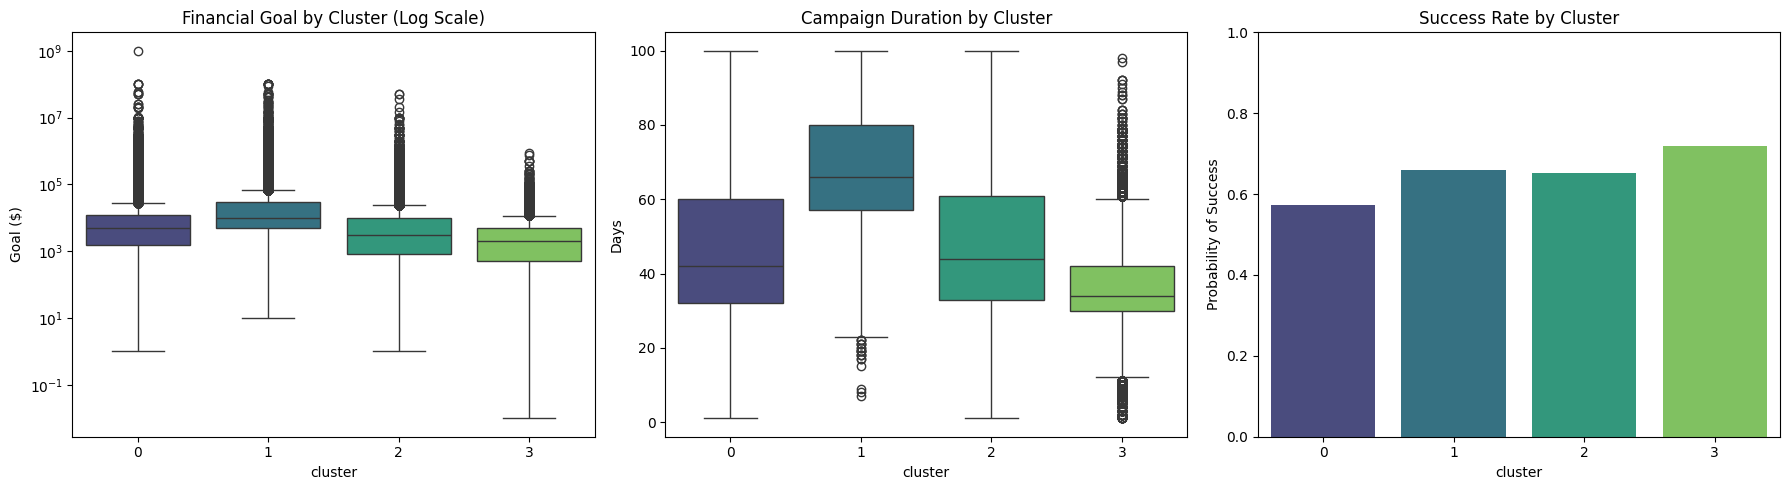

In [ ]:
# aggregating mean and median to spot skewness
profile_num = df.groupby('cluster').agg({
    'goal': ['median', 'mean'],
    'duration_days': ['mean'],
    'blurb_len': ['mean'],
    'target': ['mean', 'count']  # Success Rate & Size
}).round(2)

# Flatten columns for clean display
profile_num.columns = ['_'.join(col) for col in profile_num.columns]
print("### Numerical Profile ###")
print(profile_num)
print("-" * 50)

# which are top 2 categories in each cluster?
print("\n### Top Categories by Cluster ###")
for c in sorted(df['cluster'].unique()):
    top_cats = df[df['cluster'] == c]['category'].value_counts().head(2)
    print(f"Cluster {c}: {top_cats.index.tolist()} (Top count: {top_cats.values[0]})")

# --- VISUALIZATIONS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Chart 1: Goal Distribution (Log Scale because goals vary wildly)
sns.boxplot(x='cluster', y='goal', data=df, ax=axes[0], palette='viridis')
axes[0].set_yscale('log')
axes[0].set_title('Financial Goal by Cluster (Log Scale)')
axes[0].set_ylabel('Goal ($)')

# Chart 2: Duration Distribution
sns.boxplot(x='cluster', y='duration_days', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Campaign Duration by Cluster')
axes[1].set_ylabel('Days')

# Chart 3: Success Rate Bar Chart
success_rates = df.groupby('cluster')['target'].mean().reset_index()
sns.barplot(x='cluster', y='target', data=success_rates, ax=axes[2], palette='viridis')
axes[2].set_title('Success Rate by Cluster')
axes[2].set_ylabel('Probability of Success')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 9. Advanced Visualization (Resampling)
Visualizing high-dimensional clusters on a dataset of this size can be computationally expensive and suffer from overplotting. We **resample** a representative subset of the data to create clear, performant visualizations (like PCA or t-SNE projections) of our new personas.

--- CLUSTERING TOURNAMENT RESULTS ---
Running K-Means (k=4)...
Running Gaussian Mixture (k=4)...
Running DBSCAN (eps=0.5)...


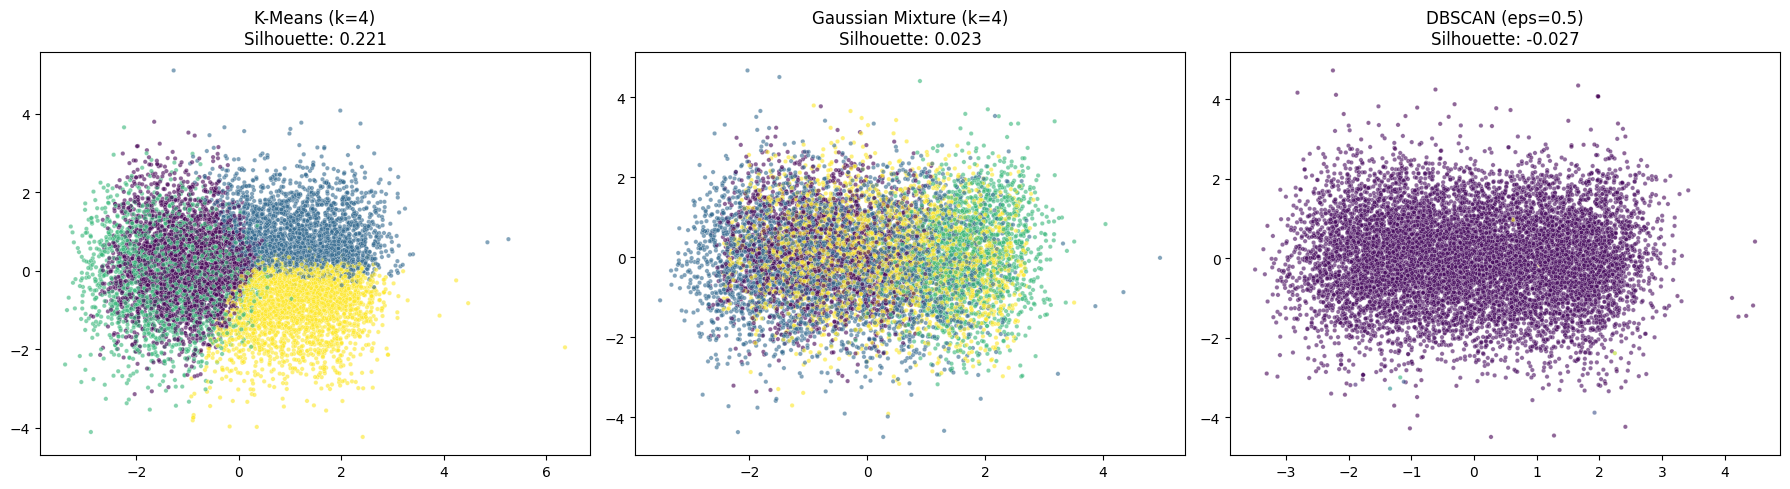



                Algorithm  Clusters Found  Silhouette Score
0           K-Means (k=4)               4             0.221
1  Gaussian Mixture (k=4)               4             0.023
2        DBSCAN (eps=0.5)              37            -0.027


In [ ]:
from sklearn.utils import resample 

# 1. Prepare & Scale Data
cluster_cols = ['log_goal', 'duration_days', 'name_len', 'blurb_len', 'name_word_count']
X_cluster = df[cluster_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 2. Define Models (Hierarchical Removed for speed/memory safety)
models = {
    "K-Means (k=4)": KMeans(n_clusters=4, random_state=42, n_init=10),
     #"Hierarchical (k=4)": AgglomerativeClustering(n_clusters=4), # had to REMOVE hierarchical as it was giving me memory issues and RAM right now costs 2 kidneys and an eye.
    "Gaussian Mixture (k=4)": GaussianMixture(n_components=4, random_state=42),
    "DBSCAN (eps=0.5)": DBSCAN(eps=0.5, min_samples=5) 
}

# 3. PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. Tournament Loop
results = []
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

print("--- CLUSTERING TOURNAMENT RESULTS ---")

for i, (name, model) in enumerate(models.items()):
    print(f"Running {name}...")
    
    # Fit on FULL data
    labels = model.fit_predict(X_scaled)
    
    # Calculate Score 
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_clusters > 1:
        # Sample 10,000 points just to calculate the score quickly (seconds vs hours)
        X_sample, labels_sample = resample(X_scaled, labels, n_samples=10000, random_state=42)
        sil = silhouette_score(X_sample, labels_sample)
    else:
        sil = -1
        
    results.append({
        "Algorithm": name,
        "Clusters Found": n_clusters,
        "Silhouette Score": sil
    })
    
    # Visualize
    plot_idx = np.random.choice(len(X_pca), size=10000, replace=False)
    sns.scatterplot(
        x=X_pca[plot_idx, 0], y=X_pca[plot_idx, 1], 
        hue=labels[plot_idx], palette='viridis', 
        ax=axes[i], alpha=0.6, s=10, legend=False
    )
    axes[i].set_title(f"{name}\nSilhouette: {sil:.3f}")

plt.tight_layout()
plt.show()

# 5. Leaderboard
results_df = pd.DataFrame(results).sort_values(by='Silhouette Score', ascending=False)
print("\n")
print(results_df.round(3))

## 10. Conclusion & Next Steps
We have successfully predicted campaign success with ~88% accuracy and identified four distinct campaign types. Future work could involve:
- **NLP Analysis:** Using TF-IDF on the 'blurb' text.
- **Deployment:** Building a Streamlit app for creators.